**Import Libraries**

In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats
import pylab
import datetime
from time import time
import seaborn as sns
sns.set()
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

#time series Libraries
import statsmodels.graphics.tsaplots as sgt 
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller

**Import the data**

In [500]:
raw_csv_data = pd.read_csv("Complete_Sentech_Tower_Data.csv")

**Make a copy of original data**

In [501]:
sentech_data= raw_csv_data.copy()

In [502]:
sentech_data

,Date,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Lightning_Warnings,Reset_secs,_Normalized_Efield,_Normalized_Warnings
0,2021-11-01 00:00:00,18.83013,44.34569,6.449132,0.0,823.9045,-31.68846,0.0,0.0,-0.001249,0.0
1,2021-11-01 00:15:00,15.88538,60.16803,8.188042,0.0,824.1832,-23.84491,0.0,0.0,-0.000939,0.0
2,2021-11-01 00:30:00,15.17229,67.91439,9.302760,0.0,824.1583,-23.84614,0.0,0.0,-0.000940,0.0
3,2021-11-01 00:45:00,14.64727,71.04126,9.468879,0.0,824.1239,-23.22135,0.0,0.0,-0.000915,0.0
4,2021-11-01 01:00:00,14.49834,72.94492,9.719332,0.0,823.9849,-23.84927,0.0,0.0,-0.000940,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11419,2022-02-27 22:45:00,16.28638,76.22140,12.107980,0.0,827.9321,-14.43517,0.0,0.0,-0.000569,0.0
11420,2022-02-27 23:00:00,15.94644,79.59342,12.436280,0.0,827.6857,-15.37659,0.0,0.0,-0.000606,0.0
11421,2022-02-27 23:15:00,15.81320,81.01760,12.576650,0.0,827.6407,-17.25920,0.0,0.0,-0.000680,0.0
11422,2022-02-27 23:30:00,15.98598,82.16581,12.960260,0.0,827.4928,-17.88704,0.0,0.0,-0.000705,0.0


In [503]:
sentech_data.describe()

,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Lightning_Warnings,Reset_secs,_Normalized_Efield,_Normalized_Warnings
count,11424.000000,11424.000000,11424.000000,11424.000000,11424.000000,11424.000000,11424.000000,11424.000000,11424.000000,11424.000000
mean,18.666664,72.062334,12.800516,0.000035,825.425774,-19.896693,0.108456,314.052871,-0.000784,0.003081
std,3.976131,20.536398,3.133315,0.002646,32.862754,236.639048,0.310969,964.622489,0.009324,0.008834
min,0.000000,0.000000,-3.143647,0.000000,0.000000,-2523.927000,0.000000,0.000000,-0.099442,0.000000
25%,15.741075,57.699713,11.769175,0.000000,825.399350,-41.415715,0.000000,0.000000,-0.001632,0.000000
50%,18.310145,74.093910,13.449530,0.000000,826.821350,-29.795150,0.000000,0.000000,-0.001174,0.000000
75%,21.583000,89.249578,14.792847,0.000000,828.124700,-19.454477,0.000000,0.000000,-0.000767,0.000000
max,29.734370,99.980700,19.050590,0.200000,833.690200,2562.246000,1.000000,3600.000000,0.100952,0.028410


In [504]:
sentech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11424 entries, 0 to 11423
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  11424 non-null  object 
 1   Air_temp              11424 non-null  float64
 2   RH                    11424 non-null  float64
 3   DewPoint              11424 non-null  float64
 4   Rain                  11424 non-null  float64
 5   Pressure              11424 non-null  float64
 6   Efield                11424 non-null  float64
 7   Lightning_Warnings    11424 non-null  float64
 8   Reset_secs            11424 non-null  float64
 9   _Normalized_Efield    11424 non-null  float64
 10  _Normalized_Warnings  11424 non-null  float64
dtypes: float64(10), object(1)
memory usage: 981.9+ KB


**Visualize the data**

Graphs:

<AxesSubplot:title={'center':'Electric Field'}>

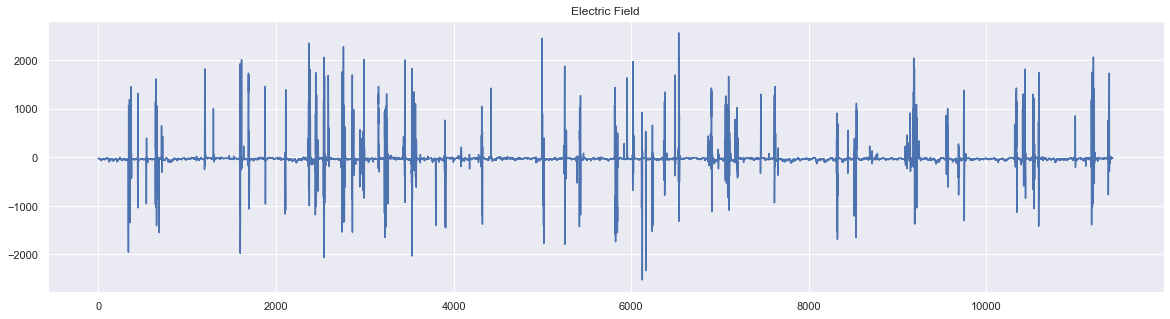

In [505]:
sentech_data.Efield.plot(figsize= (20,5), title= "Electric Field")

<AxesSubplot:title={'center':'Lightning Warnings'}>

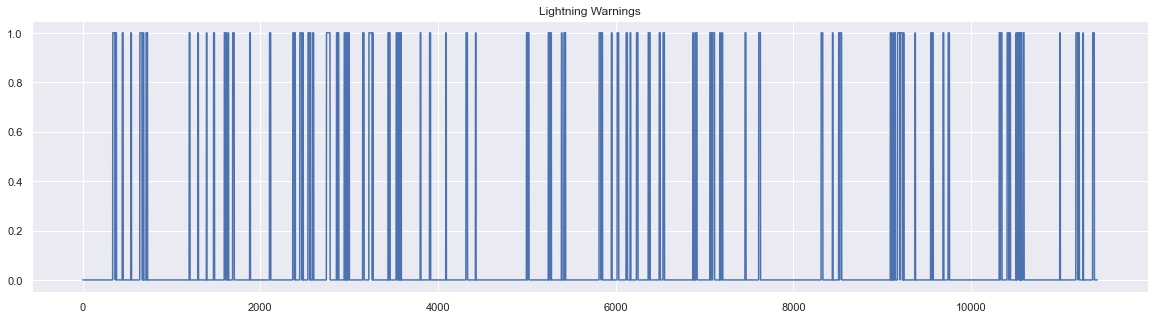

In [506]:
sentech_data.Lightning_Warnings.plot(figsize= (20,5), title= "Lightning Warnings")

Text(0.5, 1.0, 'Electric field vs Lightning Warnings')

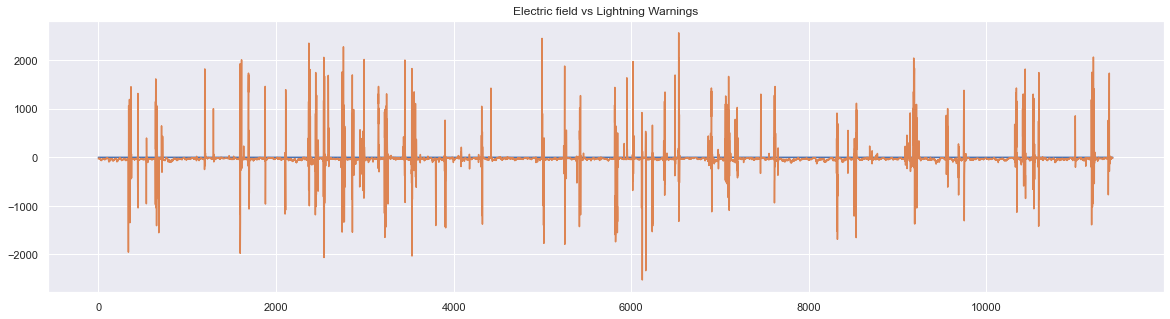

In [507]:
sentech_data.Lightning_Warnings.plot(figsize= (20,5), title= "Lightning Warnings")
sentech_data.Efield.plot(figsize= (20,5), title= "Electric Field")
plt.title("Electric field vs Lightning Warnings")

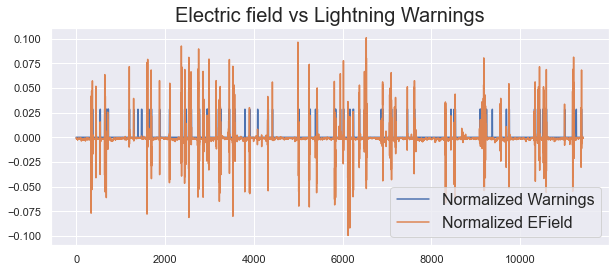

In [508]:
plt.figure(figsize=(10,4))

plt.plot(sentech_data._Normalized_Warnings)
plt.plot(sentech_data._Normalized_Efield)

plt.legend(('Normalized Warnings', 'Normalized EField'), fontsize=16)
plt.title('Electric field vs Lightning Warnings', fontsize=20)
for year in range(2022,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Lightning Warnings')

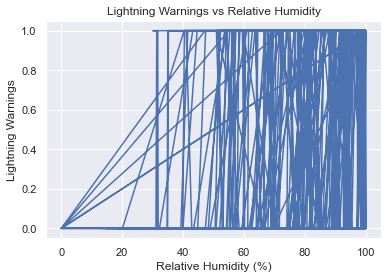

In [509]:
plt.plot(sentech_data.RH, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Lightning Warnings')

Text(0, 0.5, 'Lightning Warnings')

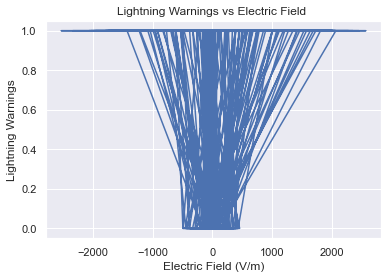

In [510]:
plt.plot(sentech_data.Efield, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Electric Field ')
plt.xlabel('Electric Field (V/m)')
plt.ylabel('Lightning Warnings')

Text(0, 0.5, 'Lightning Warnings')

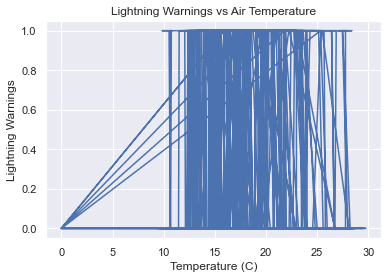

In [511]:
plt.plot(sentech_data.Air_temp, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Air Temperature')
plt.xlabel('Temperature (C)')
plt.ylabel('Lightning Warnings')

Text(0, 0.5, 'Lightning Warnings')

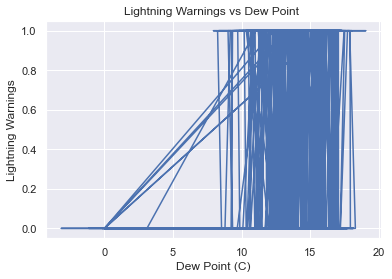

In [512]:
plt.plot(sentech_data.DewPoint, sentech_data.Lightning_Warnings)
plt.title('Lightning Warnings vs Dew Point ')
plt.xlabel('Dew Point (C)')
plt.ylabel('Lightning Warnings')

**More Sophisticated Data Exploration**

In [513]:
##Total Number of lightning warnings
warning = sentech_data[sentech_data.Lightning_Warnings==1]
warning.shape

(1239, 11)

In [514]:
##NO Lightning Warning Given
normal_condition = sentech_data[sentech_data.Lightning_Warnings==0]
normal_condition.shape

(10185, 11)

Average of all columns per wether there is lighning or not

In [515]:
sentech_data.groupby('Lightning_Warnings').mean()

,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Reset_secs,_Normalized_Efield,_Normalized_Warnings
Lightning_Warnings,,,,,,,,,
0.0,18.873257,70.585354,12.664526,0.000000,825.271119,-31.905660,0.000000,-0.001257,0.00000
1.0,16.968407,84.203604,13.918395,0.000323,826.697096,78.821091,2895.673931,0.003106,0.02841


**CORRELATIONS**

In [516]:
sentech_data.corr()

,Air_temp,RH,DewPoint,Rain,Pressure,Efield,Lightning_Warnings,Reset_secs,_Normalized_Efield,_Normalized_Warnings
Air_temp,1.000000,-0.787702,-0.077273,-0.015733,0.167639,-0.039332,-0.148976,-0.142931,-0.039332,-0.148976
RH,-0.787702,1.000000,0.612915,0.010354,0.154772,0.054286,0.206212,0.197879,0.054286,0.206212
DewPoint,-0.077273,0.612915,1.000000,-0.003409,0.166715,0.036891,0.124441,0.119576,0.036891,0.124441
Rain,-0.015733,0.010354,-0.003409,1.000000,0.000342,-0.050214,0.037939,0.045078,-0.050214,0.037939
Pressure,0.167639,0.154772,0.166715,0.000342,1.000000,-0.002614,0.013494,0.012914,-0.002614,0.013494
Efield,-0.039332,0.054286,0.036891,-0.050214,-0.002614,1.000000,0.145507,0.170194,1.000000,0.145507
Lightning_Warnings,-0.148976,0.206212,0.124441,0.037939,0.013494,0.145507,1.000000,0.933489,0.145507,1.000000
Reset_secs,-0.142931,0.197879,0.119576,0.045078,0.012914,0.170194,0.933489,1.000000,0.170194,0.933489
_Normalized_Efield,-0.039332,0.054286,0.036891,-0.050214,-0.002614,1.000000,0.145507,0.170194,1.000000,0.145507
_Normalized_Warnings,-0.148976,0.206212,0.124441,0.037939,0.013494,0.145507,1.000000,0.933489,0.145507,1.000000


In [517]:
#Correlation Matrix- Self Correlation
# using shift function to shift the values.
values= pd.DataFrame(sentech_data.Lightning_Warnings)

dataframe = pd.concat([values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)
# naming the columns
dataframe.columns = ['t', 't+1', 't+2', 't+3']
 
# using corr() function to compute the correlation
result = dataframe.corr()
 
print(result)

            t       t+1       t+2       t+3
t    1.000000  0.904037  0.810789  0.726595
t+1  0.904037  1.000000  0.904038  0.810791
t+2  0.810789  0.904038  1.000000  0.904039
t+3  0.726595  0.810791  0.904039  1.000000


**Simplyifying the data set**

In [518]:
# Create a new column extracted from sentech tower
sentech_data['warnings']=sentech_data.Lightning_Warnings

In [519]:
#Delete the other columns
del sentech_data['Air_temp']
del sentech_data['DewPoint']
del sentech_data['Rain']
del sentech_data['Pressure']
del sentech_data['Lightning_Warnings']
del sentech_data['Reset_secs']
del sentech_data['_Normalized_Warnings']
del sentech_data['Efield']
del sentech_data['_Normalized_Efield']

In [520]:
del sentech_data['Date']

In [521]:
sentech_data

,RH,warnings
0,44.34569,0.0
1,60.16803,0.0
2,67.91439,0.0
3,71.04126,0.0
4,72.94492,0.0
...,...,...
11419,76.22140,0.0
11420,79.59342,0.0
11421,81.01760,0.0
11422,82.16581,0.0


**Define Important Functions**

In [522]:
from numpy import log,dot,exp,shape

In [523]:
from sklearn.datasets import make_classification

In [524]:
#Normalizing Function (All independent parameters as well as estimation parameters)
def standardize(X_tr):
    for i in range(shape(X_tr)[0]):
        X_tr[:] = (X_tr[:] - np.mean(X_tr[:]))/np.std(X_tr[:])

In [525]:
#F-1 Score
def f1_score(y,y_hat):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(y)):
        if y[i] == 1 and y_hat[i] == 1:
            tp += 1
        elif y[i] == 1 and y_hat[i] == 0:
            fn += 1
        elif y[i] == 0 and y_hat[i] == 1:
            fp += 1
        elif y[i] == 0 and y_hat[i] == 0:
            tn += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return f1_score

In [659]:
class LogidticRegression:
    def sigmoid(self,z):
        sig = 1/(1+exp(-z))
        return sig
    def initialize(self,X):
        weights = np.zeros((shape(X)[0]))
        X = np.c_[np.ones((shape(X)[0])),X]
        return weights,X
    def fit(self,X,y,alpha=0.001,iter=400):
        weights,X = self.initialize(X)
        def cost(theta):
            z = dot(X,theta)
            cost0 = y.T.dot(log(self.sigmoid(z)))
            cost1 = (1-y).T.dot(log(1-self.sigmoid(z)))
            cost = -((cost1 + cost0))/len(y)
            return cost
        cost_list = np.zeros(iter,)
        for i in range(iter):
            weights = weights - alpha*dot(X.T,self.sigmoid(dot(X,0))-np.reshape(y,(len(y),1)))
            cost_list[i] = cost(weights)
        self.weights = weights
        return cost_list
    def predict(self,X):
        z = dot(self.initialize(X)[1],self.weights)
        lis = []
        for i in self.sigmoid(z):
            if i>0.5:
                lis.append(1)
            else:
                lis.append(0)
        return lis

In [660]:
sentech_data.shape

(11424, 2)

**Splitting the data**

In [661]:
X_te= pd.read_csv("Test_dataframe.csv")
y_te= pd.read_csv("Test_dataframe.csv")

In [662]:
X_tr= pd.read_csv("train_dataframe.csv")
y_tr= pd.read_csv("train_dataframe.csv")

In [663]:
#We want X of test
#Delete Y column of test
del X_te['warnings']
del X_te['Date']

In [664]:
#We want X of train
#Delete Y column of train
del X_tr['warnings']
del X_tr['Date']

In [665]:
#We want Y of test
#Delete X column of test
del y_te['RH']
del y_te['Date']

In [666]:
#We want Y of train
#Delete X column of train set
del y_tr['RH']
del y_tr['Date']

In [667]:
X_tr.shape

(8568, 1)

In [668]:
#X,y = make_classification(4)
#from sklearn.model_selection import train_test_split  
#X_tr,X_te,y_tr,y_te = train_test_split(sentech_data.RH,sentech_data.warnings,test_size=0.2)
X_tr= X_tr.to_numpy()
X_te= X_te.to_numpy()
y_tr= y_tr.to_numpy()
y_te= y_te.to_numpy()

**Standardize the data**

In [669]:
standardize(X_te)

In [670]:
standardize(X_tr)

**Train self made model**

In [671]:
obj1 = LogidticRegression()

In [672]:
y_tr.shape

(8568, 1)

In [673]:
X_tr.shape

(8568, 1)

In [674]:
model= obj1.fit(X_tr,y_tr)

ValueError: operands could not be broadcast together with shapes (8568,) (2,2) 

In [456]:
y_pred = obj1.predict(X_te)

AttributeError: 'LogidticRegression' object has no attribute 'weights'

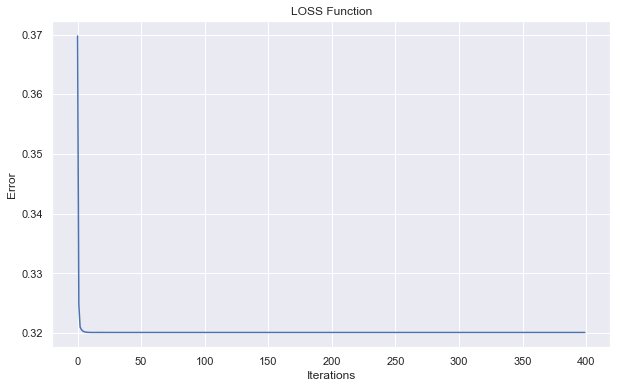

In [544]:
iterate = np.arange(0,400)

plt.title("LOSS Function") 
plt.xlabel("Iterations") 
plt.ylabel("Error") 
plt.plot(iterate,model) 
plt.show()

In [547]:
f1_score_tr = f1_score(y_tr,y_trained)
f1_score_te = f1_score(y_te,y_pred)

IndexError: list index out of range

In [546]:
print(f1_score_tr)

1.0


**Training the IN_BUILD  Logistic Regression Model**

In [124]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [125]:
model.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [127]:
y_predicted = model.predict(X_test)

**Model Results**

In [128]:
#Binary Prediction
model.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [129]:
#Probability Prediction (0,1)
model.predict_proba(X_test)

array([[0.8488316 , 0.1511684 ],
       [0.85089007, 0.14910993],
       [0.87683849, 0.12316151],
       ...,
       [0.88273772, 0.11726228],
       [0.87765915, 0.12234085],
       [0.86013642, 0.13986358]])

In [130]:
#Model Accuracy
model.score(X_test,y_test)

0.8774617067833698

In [131]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [132]:
def prediction_function(Humidity):
    z = 0.042 * Humidity - 1.53 # 0.04150133 ~ 0.042 and -1.52726963 ~ -1.53
    y = sigmoid(z)
    return y

In [133]:
#Make easy prediction by changing value of Humidity
Humidity= 20
prediction_function(Humidity)

0.3340330732481797

In [134]:
# Show the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted)

array([[2005,    0],
       [ 280,    0]], dtype=int64)